In [1]:
import ast

from tqdm import tqdm
import pandas as pd

from app.utils.helpers import compute_german_confidence
from masterarbeit.utils.utils import plot_metric, get_node_recall
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = None

hp_columns = ["embed_model", "llm", "chunk_size", "top_k", "rerank_model"]

data_retrieval = pd.read_csv("eval-retrieval-meta--llama3.1-70b-instruct_context_relevance_with_cot.csv")
data_gen = pd.read_csv("eval-full-judgement-ref-free-cr-ar-gr-cr.csv")

2025-08-06 09:39:37,260 - app.controllers.tenants.tenant_controller - INFO - Using tenant: SovantaTenant


In [ ]:
# Compute Recall
# data_retrieval["nodes_recall_0.5"] = data_retrieval.progress_apply(lambda row: get_node_recall(row, lcs_thresh=0.5), axis=1)
# data_retrieval.to_csv("pred-retrieval-2025-05-25_22_56_07.csv")

# Add Context Relevance to Generation Data
# key_cols = ['embed_model', 'chunk_size', 'top_k', 'prompt', 'rerank_model']
# df_merged = pd.merge(
#    data_gen,
#    data_retrieval[key_cols + ['meta--llama3.1-70b-instruct_context_relevance_with_cot']],
#    on=key_cols,
#    how='left'
# )
# df_merged.to_csv("eval-judgement-cr.csv")

Failure rate of judges

In [17]:
for col in [
    col
    for col in data_retrieval.columns
    if ("judgement" in col or "relevance" in col or "groundedness" in col) and "_meta" not in col
]:
    fails = 0
    df_f = data_retrieval[(data_retrieval[col].isna()) | (data_retrieval[col] == -1)]
    print(f"Failure rate of {col}: {len(df_f) / len(data_retrieval)}")
for col in [
    col
    for col in data_gen.columns
    if ("judgement" in col or "relevance" in col or "groundedness" in col) and "_meta" not in col
]:
    fails = 0
    if "context_relevance" in col:
        df_f = data_gen[data_gen[col] == -1]
    else:
        df_f = data_gen[(data_gen[col].isna()) | (data_gen[col] == -1)]
    print(f"Failure rate of {col}: {len(df_f) / len(data_gen)}")

Failure rate of meta--llama3.1-70b-instruct_context_relevance_with_cot: 0.0
Failure rate of meta--llama3.1-70b-instruct_judgement: 0.0
Failure rate of meta--llama3.1-70b-instruct_context_relevance_with_cot: 0.0
Failure rate of mistralai--mistral-large-instruct_answer_relevance: 0.00025025025025025025
Failure rate of meta--llama3.1-70b-instruct_judgement_ref_free: 0.00012512512512512512
Failure rate of meta--llama3.1-70b-instruct_groundedness: 0.004629629629629629


This evaluation is based on 111 real prompts from the productive system, for which gold answers as well as relevant text chunks that should be found were hand-crafted. Of these 111 prompts, 24 do not have an answer in the context, so the correct answer for the LLM is "I do not know". These samples are excluded from the Retrieval Evaluation

## 1. Retrieval Evaluation

Retrieval was tested on the following hyperparameter set:

In [56]:
for col in hp_columns:
    print(f"{col.upper()}: {'; '.join([str(s) for s in data_retrieval[col].unique()])}")

print(f"\nNumber of Data Points evaluated: {data_retrieval.shape[0]}")

EMBED_MODEL: BAAI/bge-m3; intfloat/multilingual-e5-large
LLM: nan
CHUNK_SIZE: 64; 128; 256; 512
TOP_K: 2; 4; 6; 8; 10; 12; 14
RERANK_MODEL: nan; hooman650/bge-reranker-v2-m3-onnx-o4; mixedbread-ai/mxbai-rerank-base-v1; mixedbread-ai/mxbai-rerank-xsmall-v1

Number of Data Points evaluated: 19488


## 1.1 Retrieval Recall

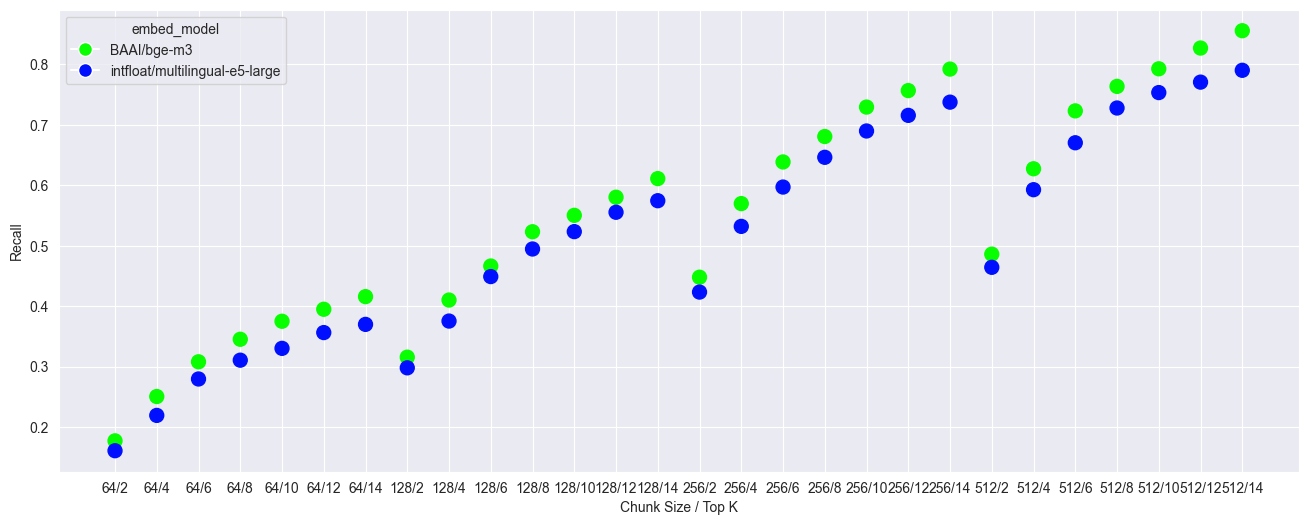

                      embed_model  mean_nodes_recall_0.5
0                     BAAI/bge-m3               0.550569
1  intfloat/multilingual-e5-large               0.514636


In [4]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "embed_model",
    "Chunk Size / Top K",
    "Recall",
    "",
)

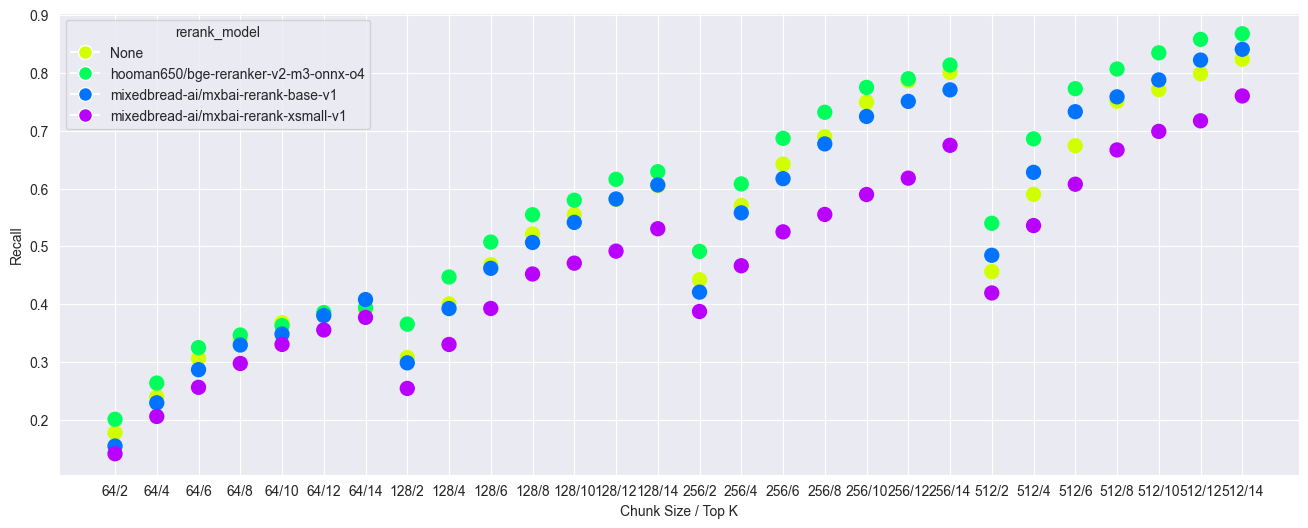

                           rerank_model  mean_nodes_recall_0.5
1  hooman650/bge-reranker-v2-m3-onnx-o4               0.580136
0                                  None               0.542469
2    mixedbread-ai/mxbai-rerank-base-v1               0.539438
3  mixedbread-ai/mxbai-rerank-xsmall-v1               0.468368


In [3]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "rerank_model",
    "Chunk Size / Top K",
    "Recall",
    "",
)

--> small rerank models are worse than no rerank --> ignore from now on

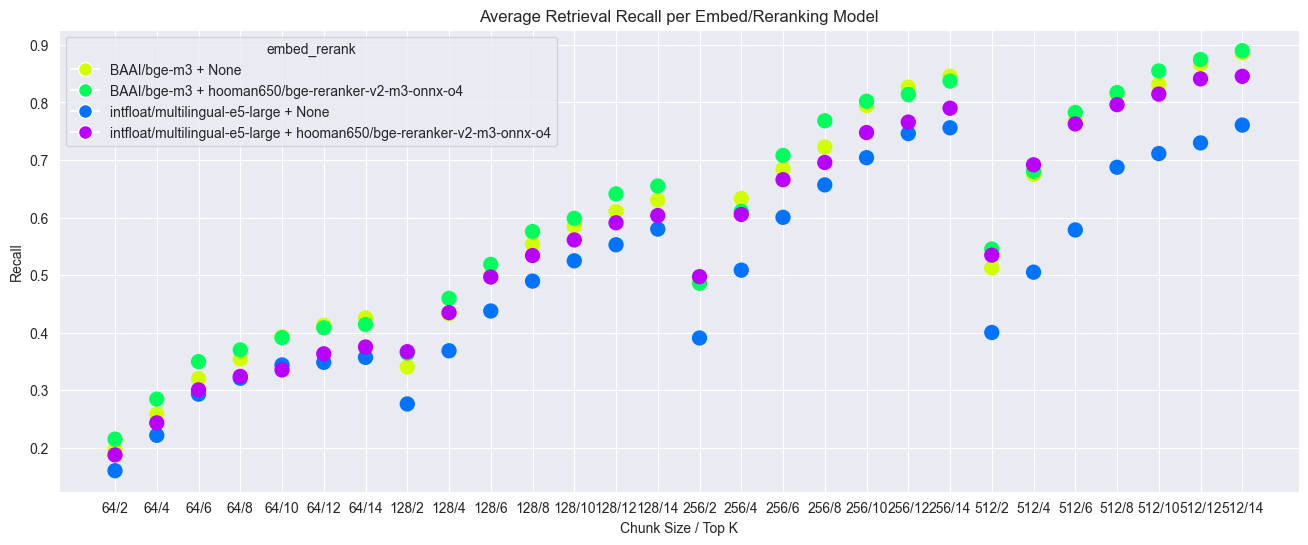

                                        embed_rerank  mean_nodes_recall_0.5
1  BAAI/bge-m3 + hooman650/bge-reranker-v2-m3-onn...               0.597023
0                                 BAAI/bge-m3 + None               0.584566
3  intfloat/multilingual-e5-large + hooman650/bge...               0.563249
2              intfloat/multilingual-e5-large + None               0.500372


In [70]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "embed_rerank",
    "Chunk Size / Top K",
    "Recall",
    "Average Retrieval Recall per Embed/Reranking Model",
    exclude_small_rerank=True,
)

Performance of English only

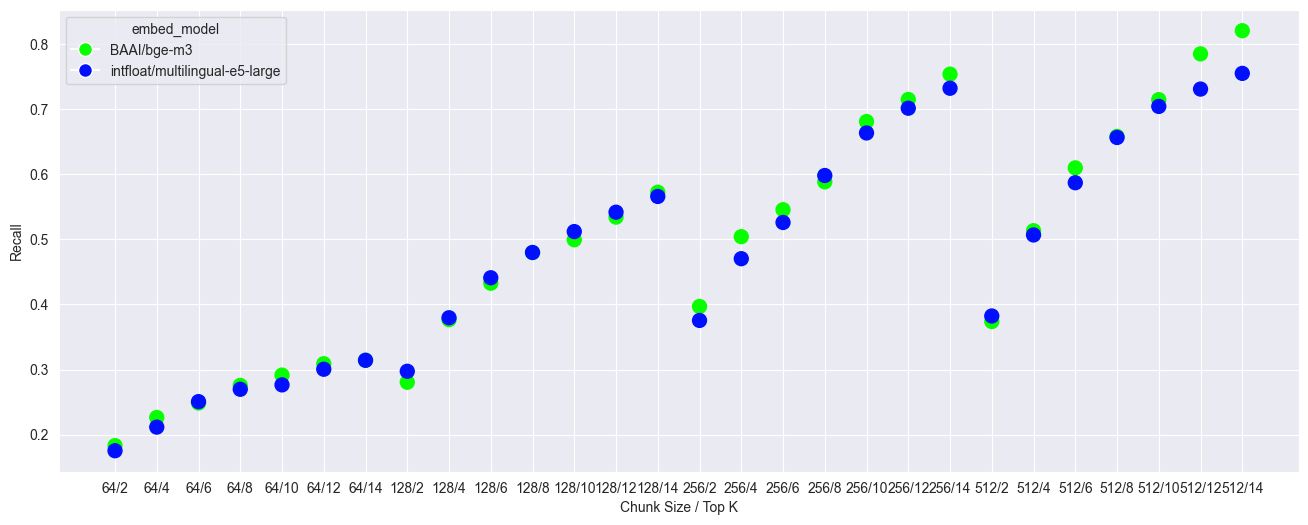

                      embed_model  mean_nodes_recall_0.5
0                     BAAI/bge-m3               0.488737
1  intfloat/multilingual-e5-large               0.478803


In [33]:
data_retrieval["language"] = data_retrieval["prompt"].apply(lambda x: compute_german_confidence(x))
data_en = data_retrieval[data_retrieval["language"] < 0.5]
plot_metric(
    data_en,
    "chunk_top_k",
    "nodes_recall_0.5",
    "embed_model",
    "Chunk Size / Top K",
    "Recall",
    "",
)

In [32]:
group = data_en.groupby(["embed_model", "rerank_model", "chunk_size", "top_k"], as_index=False, dropna=False)[
    "nodes_recall_0.5"
].mean()
print(group.nlargest(10, columns=["nodes_recall_0.5"]))

                        embed_model                          rerank_model  chunk_size  top_k  nodes_recall_0.5
111                     BAAI/bge-m3                                   NaN         512     14          0.836744
27                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         512     14          0.835140
110                     BAAI/bge-m3                                   NaN         512     12          0.834904
139  intfloat/multilingual-e5-large  hooman650/bge-reranker-v2-m3-onnx-o4         512     14          0.818083
55                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         512     14          0.812766
138  intfloat/multilingual-e5-large  hooman650/bge-reranker-v2-m3-onnx-o4         512     12          0.811632
104                     BAAI/bge-m3                                   NaN         256     14          0.800734
83                      BAAI/bge-m3  mixedbread-ai/mxbai-rerank-xsmall-v1         512     14          0.797812
2

#### Best combinations for retrieval:

In [30]:
group = data_retrieval.groupby(["embed_model", "rerank_model", "chunk_size", "top_k"], as_index=False, dropna=False)[
    "nodes_recall_0.5"
].mean()
print(group.nlargest(20, columns=["nodes_recall_0.5"]))

                        embed_model                          rerank_model  chunk_size  top_k  nodes_recall_0.5
27                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         512     14          0.889852
111                     BAAI/bge-m3                                   NaN         512     14          0.886457
26                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         512     12          0.874651
55                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         512     14          0.872904
110                     BAAI/bge-m3                                   NaN         512     12          0.867283
25                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         512     10          0.854742
104                     BAAI/bge-m3                                   NaN         256     14          0.845504
139  intfloat/multilingual-e5-large  hooman650/bge-reranker-v2-m3-onnx-o4         512     14          0.845369
5

Best combination without reranking

In [72]:
df = data_retrieval[data_retrieval["rerank_model"].isna()]
print(df.shape)
group = df.groupby(["embed_model", "chunk_size", "top_k", "rerank_model"], as_index=False, dropna=False)[
    "nodes_recall_0.5"
].mean()
print(group.nlargest(10, columns=["nodes_recall_0.5"]))

(4872, 25)
                       embed_model  chunk_size  top_k rerank_model  nodes_recall_0.5
27                     BAAI/bge-m3         512     14          NaN          0.886457
26                     BAAI/bge-m3         512     12          NaN          0.867283
20                     BAAI/bge-m3         256     14          NaN          0.845504
25                     BAAI/bge-m3         512     10          NaN          0.831036
19                     BAAI/bge-m3         256     12          NaN          0.826666
24                     BAAI/bge-m3         512      8          NaN          0.814713
18                     BAAI/bge-m3         256     10          NaN          0.794469
23                     BAAI/bge-m3         512      6          NaN          0.769484
55  intfloat/multilingual-e5-large         512     14          NaN          0.760680
48  intfloat/multilingual-e5-large         256     14          NaN          0.755952


Check if any prompt was never found

In [21]:
import json

# Step 1: Get index of max nodes_recall_0.5 per prompt
idx = data_retrieval.groupby("prompt")["nodes_recall_0.5"].idxmax()

# Step 2: Retrieve corresponding rows
group = data_retrieval.loc[idx].sort_values("nodes_recall_0.5", ascending=False)


def length(row):
    try:
        r = ast.literal_eval(row)
        return len(r)
    except:
        return -1


# Step 3: Add a column for the length of the relevant_text list
group["relevant_text_length"] = group["relevant_text"].apply(length)

# Step 4: Filter and display results
print(group[group["nodes_recall_0.5"] < 1][["prompt", "nodes_recall_0.5", "relevant_text_length"]])

                                                  prompt  nodes_recall_0.5  relevant_text_length
19201  What do I need to disclose about my Energy Con...          0.986364                    -1
9540   Give me an overview about what i can find on t...          0.955357                     6
7433                           whart a moderation sytle?          0.750000                     4
2992     Was benötige ich für Rollen beim Roadmap to CoE          0.693333                    -1
18943  What are the coding guidelines of the data sci...          0.627495                   109
6319                  Was sind die top ziele der mainova          0.500000                     6
1597                                    What is the BTP?          0.500000                     2
19223  Gib mir eine Zusammenfassung unserer aktueelle...          0.333333                     9


#### Cluster Analysis

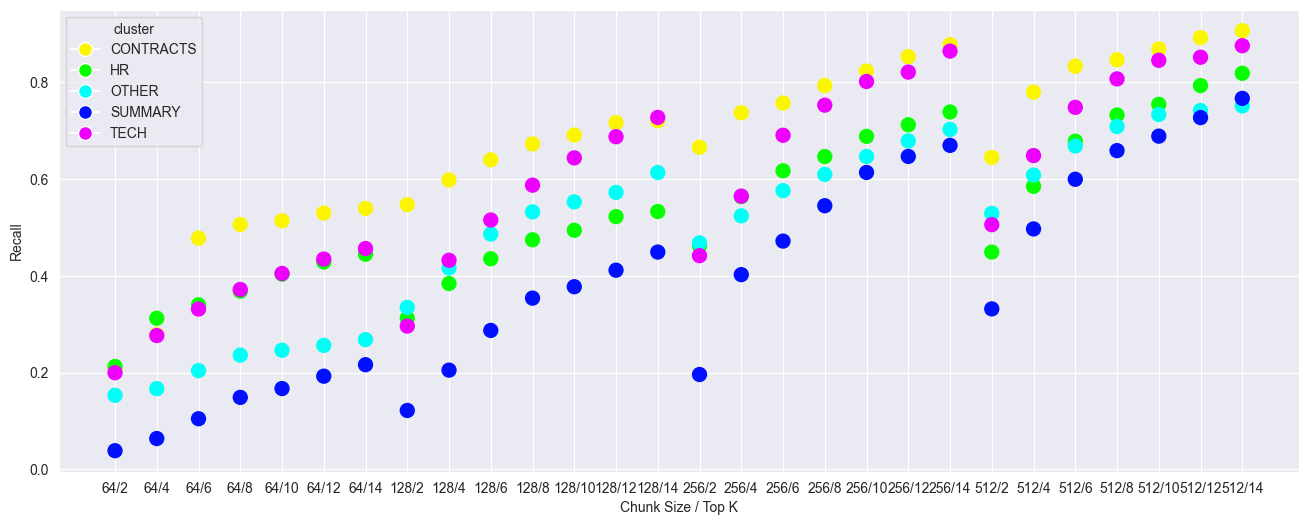

     cluster  mean_nodes_recall_0.5
0  CONTRACTS               0.675889
4       TECH               0.592563
1         HR               0.532565
2      OTHER               0.499726
3    SUMMARY               0.391365


In [10]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "cluster",
    "Chunk Size / Top K",
    "Recall",
    "",
    exclude_small_rerank=False,
)

## 1.2 Context Relevance - Llama3.1-70b

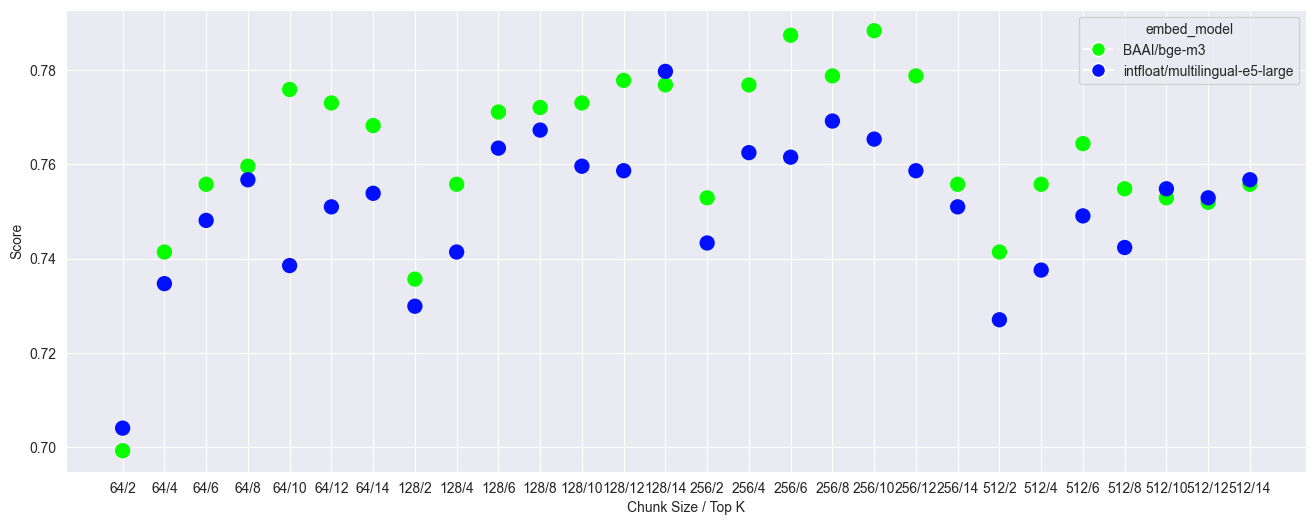

                      embed_model  mean_meta--llama3.1-70b-instruct_context_relevance_with_cot
0                     BAAI/bge-m3                                           0.761802          
1  intfloat/multilingual-e5-large                                           0.750650          


In [7]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_context_relevance_with_cot",
    "embed_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

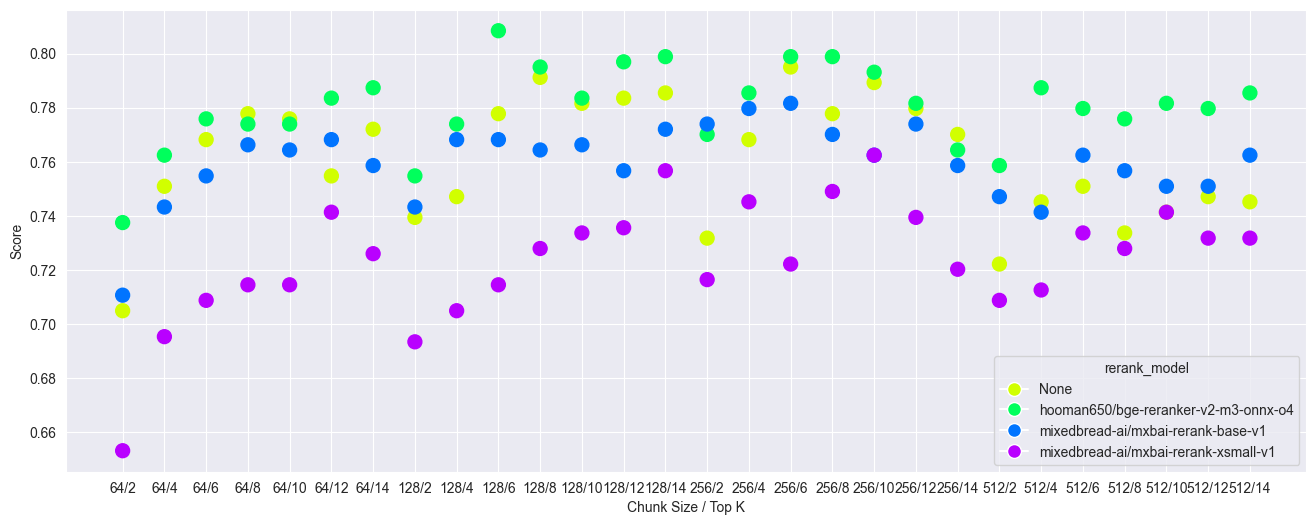

                           rerank_model  mean_meta--llama3.1-70b-instruct_context_relevance_with_cot
1  hooman650/bge-reranker-v2-m3-onnx-o4                                           0.780241          
0                                  None                                           0.761015          
2    mixedbread-ai/mxbai-rerank-base-v1                                           0.759921          
3  mixedbread-ai/mxbai-rerank-xsmall-v1                                           0.723727          


In [8]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_context_relevance_with_cot",
    "rerank_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

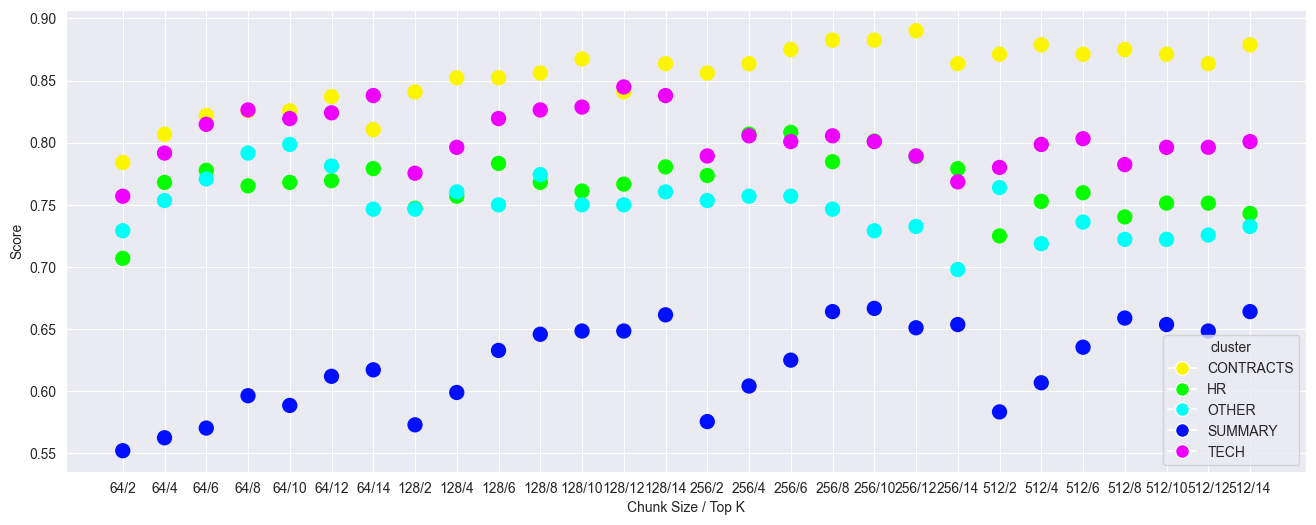

     cluster  mean_meta--llama3.1-70b-instruct_context_relevance_with_cot
0  CONTRACTS                                           0.853896          
4       TECH                                           0.804233          
1         HR                                           0.766617          
2      OTHER                                           0.748512          
3    SUMMARY                                           0.621373          


In [9]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_context_relevance_with_cot",
    "cluster",
    "Chunk Size / Top K",
    "Score",
    "",
)

Best combinations

In [16]:
group = data_retrieval.groupby(["embed_model", "rerank_model", "chunk_size", "top_k"], as_index=False, dropna=False)[
    "meta--llama3.1-70b-instruct_context_relevance_with_cot"
].mean()
print(group.nlargest(10, columns=["meta--llama3.1-70b-instruct_context_relevance_with_cot"]))

     embed_model                          rerank_model  chunk_size  top_k  meta--llama3.1-70b-instruct_context_relevance_with_cot
9    BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128      6                                           0.819923     
17   BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         256      8                                           0.816092     
12   BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128     12                                           0.812261     
44   BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         256      6                                           0.812261     
13   BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128     14                                           0.808429     
16   BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         256      6                                           0.808429     
10   BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128      8                 

In [15]:
r = data_retrieval.groupby("chunk_size")["meta--llama3.1-70b-instruct_context_relevance_with_cot"].mean()
print(r)

chunk_size
64     0.747126
128    0.761563
256    0.766420
512    0.749795
Name: meta--llama3.1-70b-instruct_context_relevance_with_cot, dtype: float64


## 1.3 Correlation between Recall and Context Relevance

In [78]:
print(data_retrieval["meta--llama3.1-70b-instruct_context_relevance_with_cot"].corr(data_retrieval["nodes_recall_0.5"]))

0.23114596970225915


Correlation per Cluster

In [79]:
for cluster in data_retrieval["cluster"].unique():
    filtered = data_retrieval[data_retrieval["cluster"] == cluster]
    print(
        f"Correlation for cluster {cluster}: {filtered['meta--llama3.1-70b-instruct_context_relevance_with_cot'].corr(filtered['nodes_recall_0.5'])}"
    )

Correlation for cluster TECH: 0.1567430387515826
Correlation for cluster HR: 0.3860233305858225
Correlation for cluster SUMMARY: -0.15428971810662911
Correlation for cluster OTHER: 0.2238511215750193
Correlation for cluster CONTRACTS: 0.30121501240767007


# 2. Generation
Hyperparameter Combinations

In [4]:
for col in hp_columns:
    print(f"{col.upper()}: {'; '.join([str(s) for s in data_gen[col].unique()])}")

print(f"\nNumber of Data Points evaluated: {data_gen.shape[0]}")

EMBED_MODEL: BAAI/bge-m3
LLM: mistralai--mistral-large-instruct; meta--llama3.1-70b-instruct
CHUNK_SIZE: 128; 256; 512
TOP_K: 4; 6; 8; 10; 12; 14
RERANK_MODEL: nan; hooman650/bge-reranker-v2-m3-onnx-o4

Number of Data Points evaluated: 7992


## 2.1 LLM-as-a-Judge

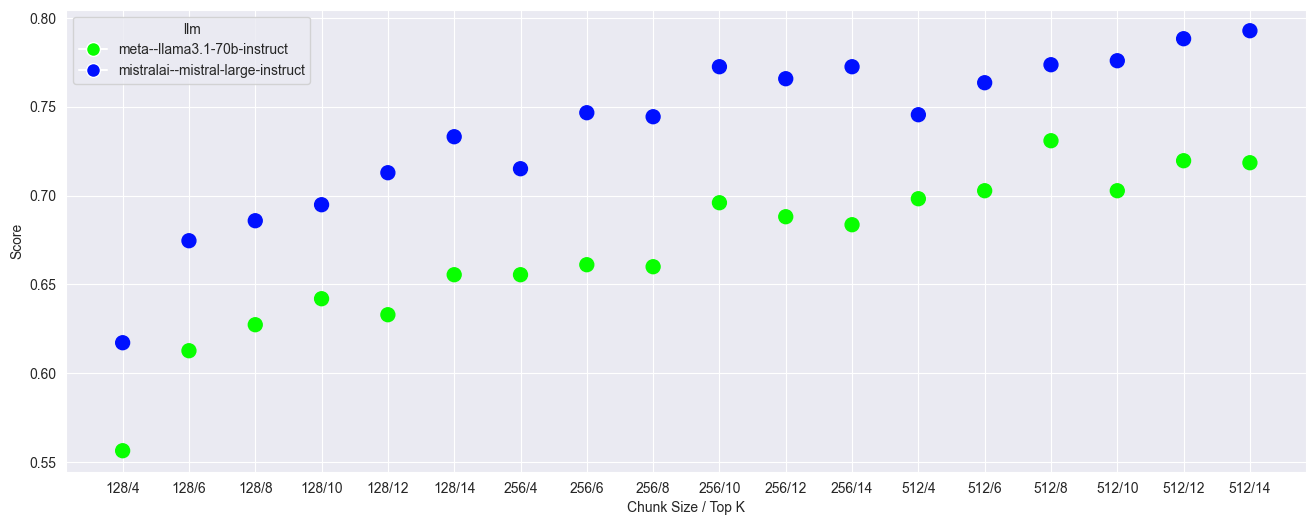

                                 llm  mean_meta--llama3.1-70b-instruct_judgement
1  mistralai--mistral-large-instruct                                    0.737487
0        meta--llama3.1-70b-instruct                                    0.669044


In [2]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_judgement",
    "llm",
    "Chunk Size / Top K",
    "Score",
    "Average LLM-Judgement-Score per LLM",
)

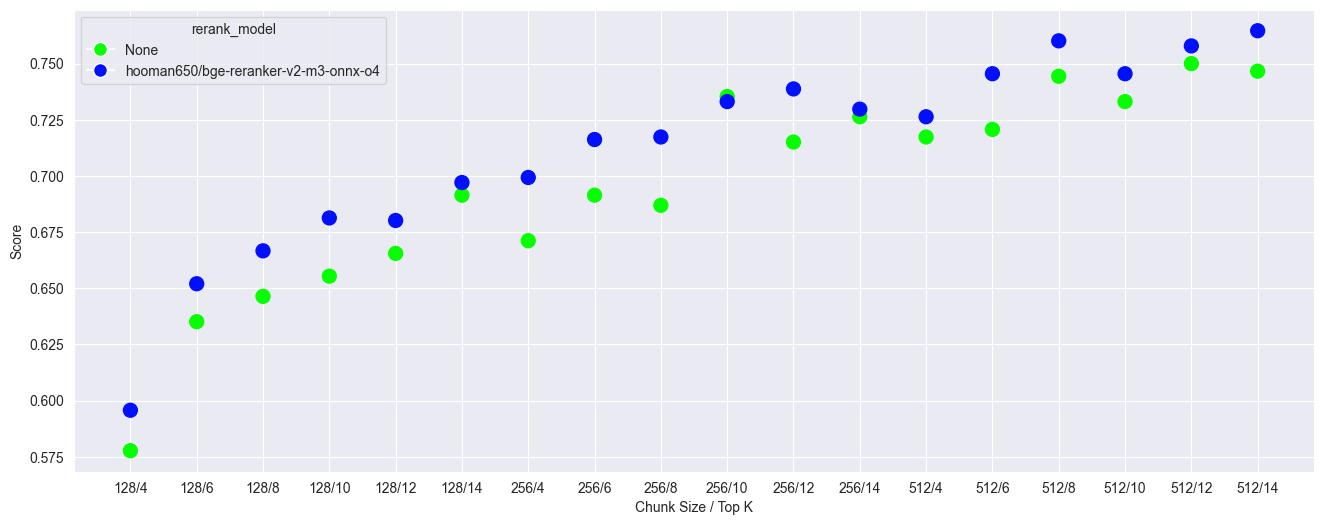

                           rerank_model  mean_meta--llama3.1-70b-instruct_judgement
1  hooman650/bge-reranker-v2-m3-onnx-o4                                    0.711524
0                                  None                                    0.695008


In [3]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_judgement",
    "rerank_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

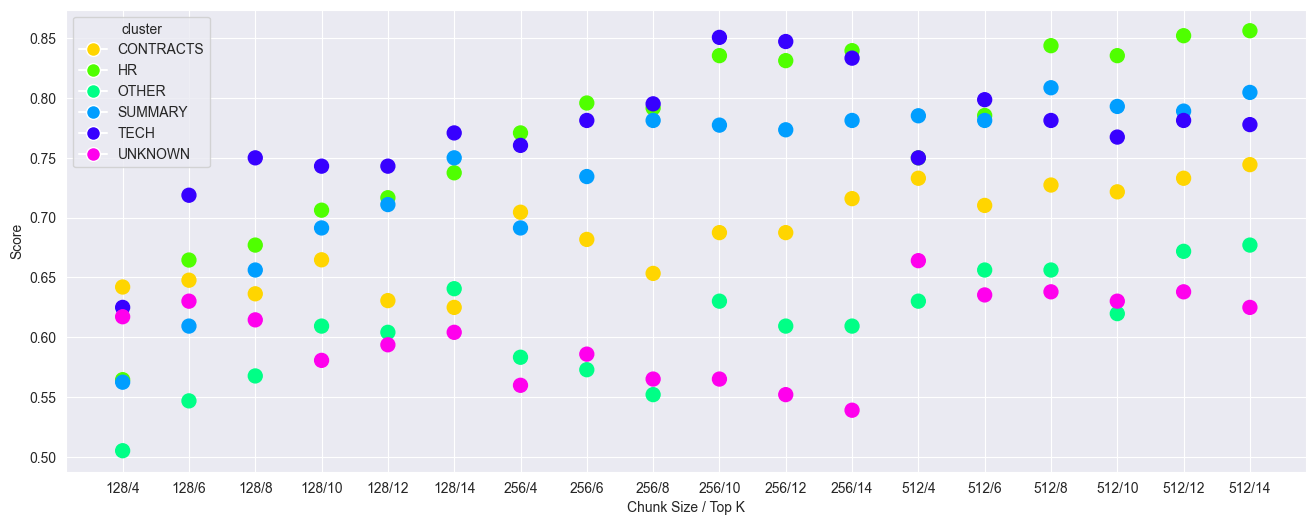

     cluster  mean_meta--llama3.1-70b-instruct_judgement
4       TECH                                    0.770833
1         HR                                    0.769676
3    SUMMARY                                    0.737847
0  CONTRACTS                                    0.685922
2      OTHER                                    0.607928
5    UNKNOWN                                    0.602141


In [4]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_judgement",
    "cluster",
    "Chunk Size / Top K",
    "Score",
    "",
)

Best combinations

In [5]:
group = data_gen.groupby(["llm", "chunk_size", "top_k", "rerank_model"], as_index=False, dropna=False)[
    "meta--llama3.1-70b-instruct_judgement"
].mean()
print(group.nlargest(10, columns=["meta--llama3.1-70b-instruct_judgement"]))

                                  llm  chunk_size  top_k                          rerank_model  meta--llama3.1-70b-instruct_judgement
70  mistralai--mistral-large-instruct         512     14  hooman650/bge-reranker-v2-m3-onnx-o4                               0.797297
68  mistralai--mistral-large-instruct         512     12  hooman650/bge-reranker-v2-m3-onnx-o4                               0.792793
71  mistralai--mistral-large-instruct         512     14                                   NaN                               0.788288
55  mistralai--mistral-large-instruct         256     10                                   NaN                               0.783784
66  mistralai--mistral-large-instruct         512     10  hooman650/bge-reranker-v2-m3-onnx-o4                               0.783784
69  mistralai--mistral-large-instruct         512     12                                   NaN                               0.783784
59  mistralai--mistral-large-instruct         256     14      

## 2.2 Legacy Metrics
### 2.2.1 BLEU

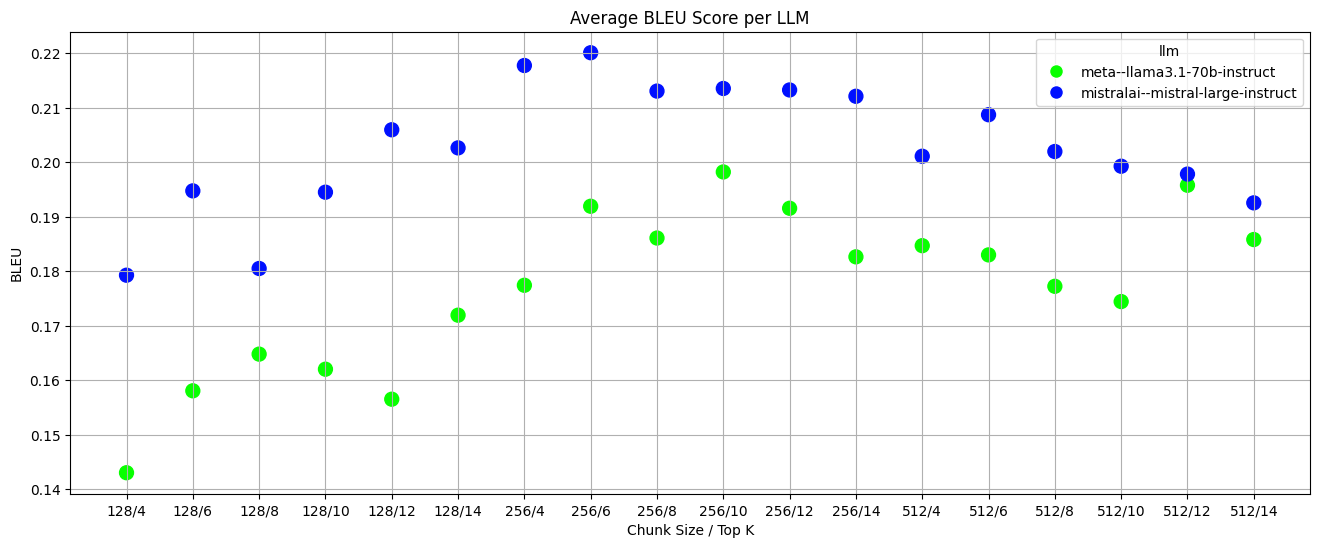

                                 llm  mean_bleu
1  mistralai--mistral-large-instruct   0.202726
0        meta--llama3.1-70b-instruct   0.176953


In [22]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "bleu",
    "llm",
    "Chunk Size / Top K",
    "BLEU",
    "Average BLEU Score per LLM",
)

### 2.2.2 ROUGE

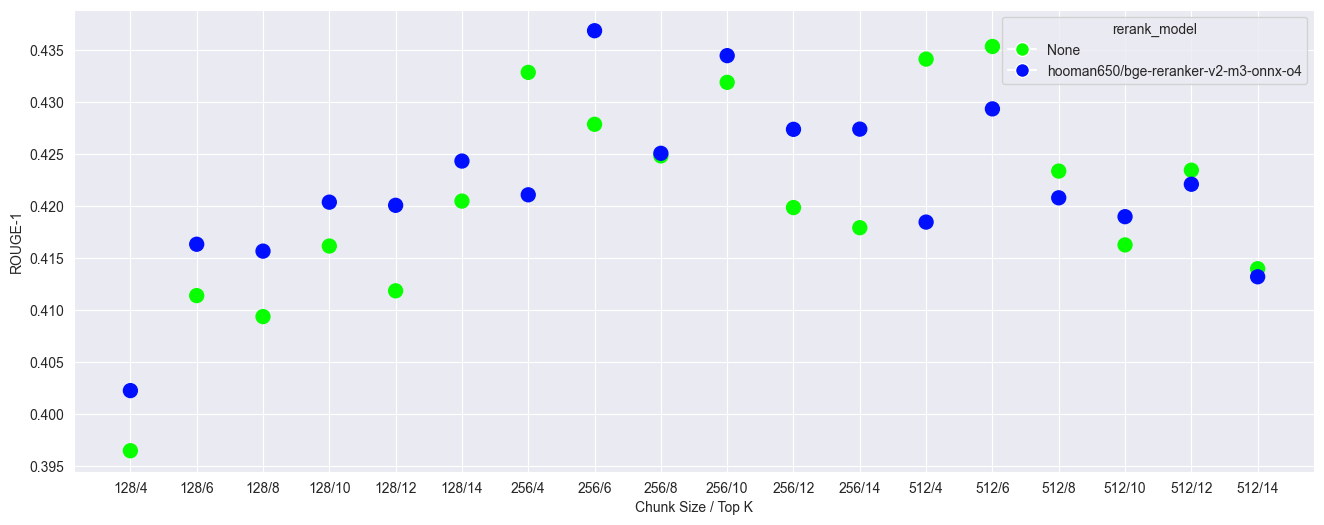

                           rerank_model  mean_rouge1
1  hooman650/bge-reranker-v2-m3-onnx-o4     0.421908
0                                  None     0.420426


In [15]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "rouge1",
    "rerank_model",
    "Chunk Size / Top K",
    "ROUGE-1",
    "",
)

### 2.2.3 BERT-Score

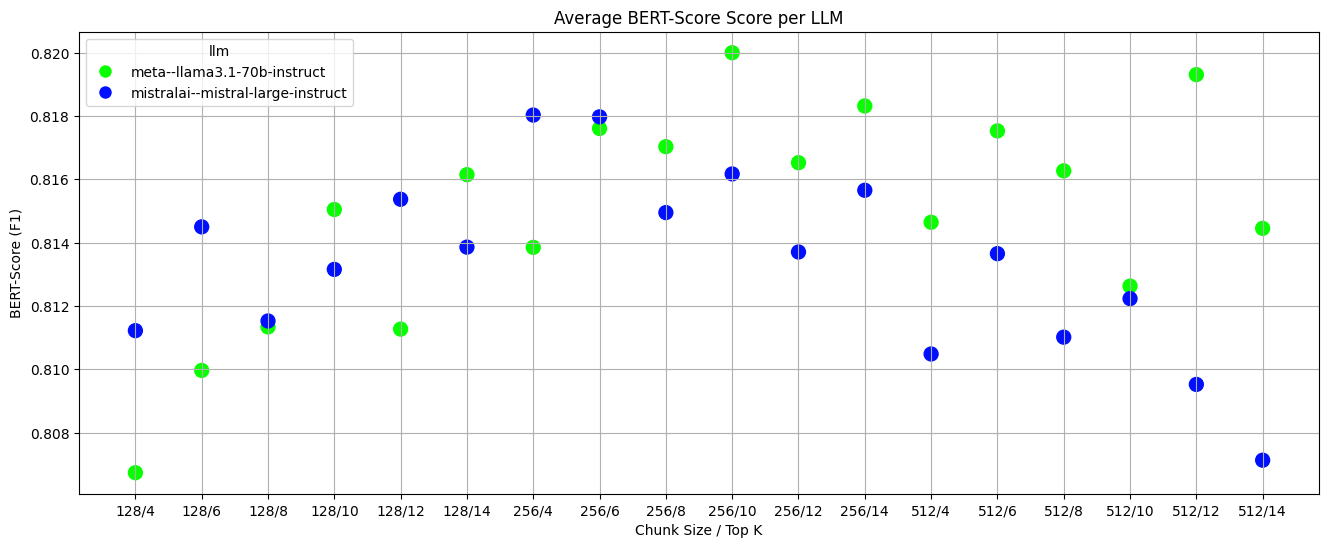

                                 llm  mean_bertscore_f1
0        meta--llama3.1-70b-instruct           0.814926
1  mistralai--mistral-large-instruct           0.813341


In [24]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "bertscore_f1",
    "llm",
    "Chunk Size / Top K",
    "BERT-Score (F1)",
    "Average BERT-Score Score per LLM",
)

## 2.3 RAG Triad
### 2.3.1 Answer Relevance

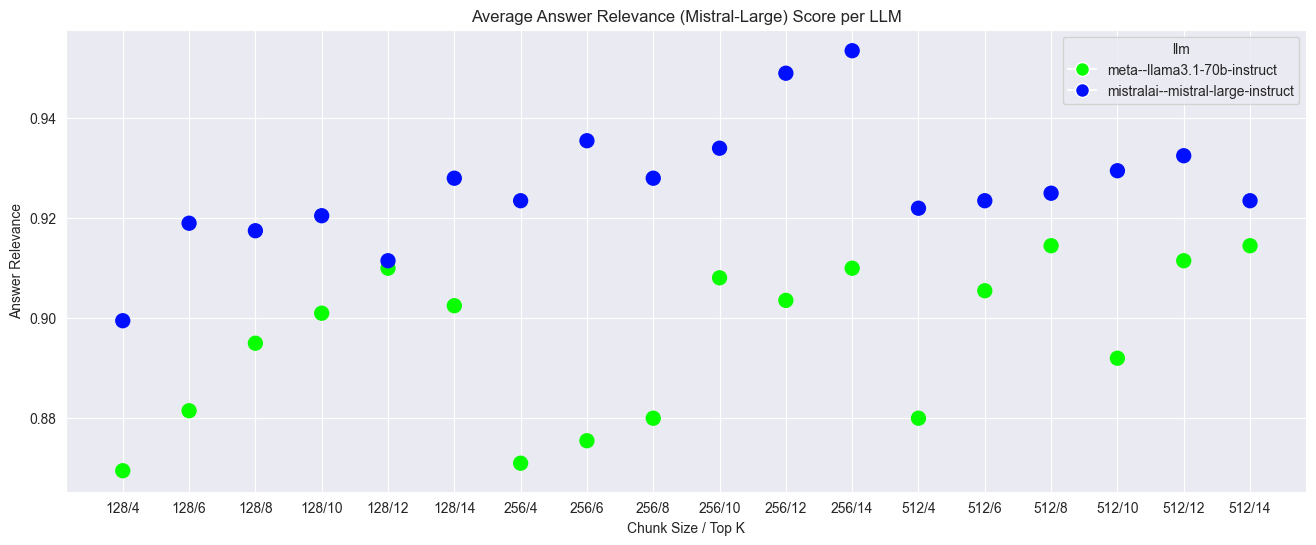

                                 llm  mean_mistralai--mistral-large-instruct_answer_relevance
1  mistralai--mistral-large-instruct                                           0.926343      
0        meta--llama3.1-70b-instruct                                           0.895765      


In [18]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "mistralai--mistral-large-instruct_answer_relevance",
    "llm",
    "Chunk Size / Top K",
    "Answer Relevance",
    "Average Answer Relevance (Mistral-Large) Score per LLM",
)

### 2.3.2 Groundedness

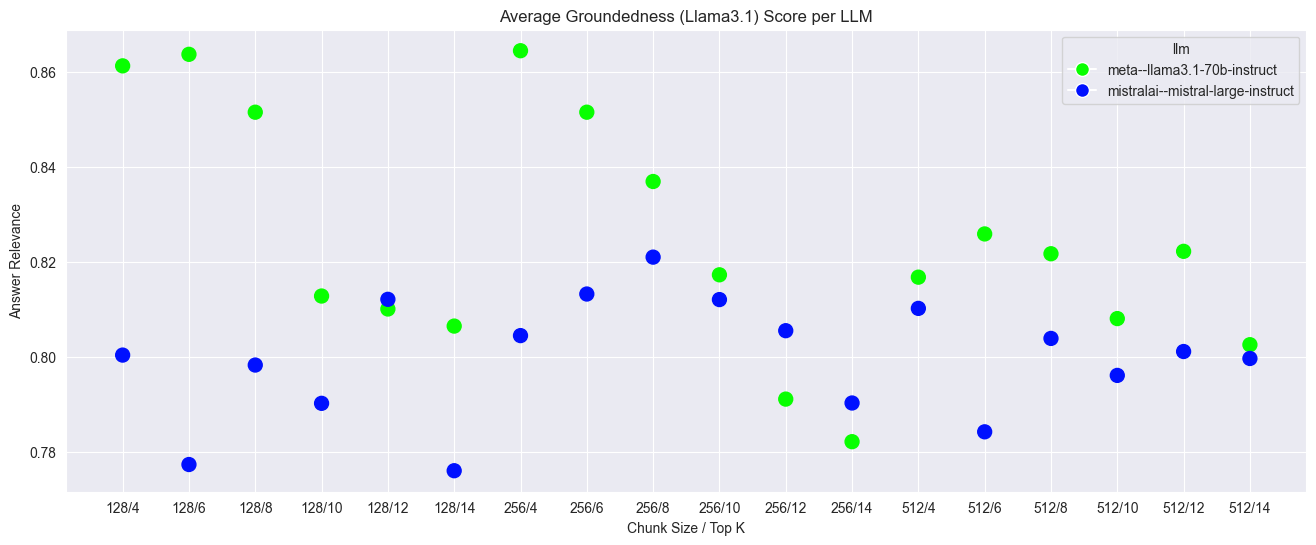

                                 llm  mean_meta--llama3.1-70b-instruct_groundedness
0        meta--llama3.1-70b-instruct                                       0.824760
1  mistralai--mistral-large-instruct                                       0.799752


In [6]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "meta--llama3.1-70b-instruct_groundedness",
    "llm",
    "Chunk Size / Top K",
    "Answer Relevance",
    "Average Groundedness (Llama3.1) Score per LLM",
)

### 2.3.3 RAG Triad Score
Lets first look at the score with all columns

In [6]:
weight_options = [
    (1 / 3, 1 / 3, 1 / 3),
    (0.5, 0.5, 0),
    (0.5, 0.25, 0.25),
    (0.25, 0.5, 0.25),
    (0.25, 0.25, 0.5),
    (0.75, 0.25, 0),
    (0.25, 0.75, 0),
]
results = []

for w1, w2, w3 in weight_options:
    weighted_avg = (
        w1 * data_gen["mistralai--mistral-large-instruct_answer_relevance"]
        + w2 * data_gen["meta--llama3.1-70b-instruct_groundedness"]
        + w3 * data_gen["meta--llama3.1-70b-instruct_context_relevance_with_cot"]
    )
    corr = weighted_avg.corr(data_gen["meta--llama3.1-70b-instruct_judgement"])
    results.append(
        {
            "answer_relevance": "mistral-large-instruct_answer_relevance",
            "groundedness": "llama3.1-70b-instruct_groundedness",
            "context_relevance": "llama3.1-70b-instruct_context_relevance_with_cot",
            "weights": (w1, w2, w3),
            "correlation": corr,
        }
    )

results_sorted = sorted(results, key=lambda x: x["correlation"], reverse=True)
ranked_df = pd.DataFrame(results_sorted)
ranked_df.head(10)

,answer_relevance,groundedness,context_relevance,weights,correlation
0,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.5, 0.25, 0.25)",0.184829
1,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.3333333333333333, 0.3333333333333333, 0.333...",0.176175
2,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.75, 0.25, 0)",0.175505
3,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.25, 0.5)",0.168462
4,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.5, 0.5, 0)",0.163652
5,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.5, 0.25)",0.158844
6,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.75, 0)",0.117836


Now again only answerable questions

In [4]:
weight_options = [
    (1 / 3, 1 / 3, 1 / 3),
    (0.5, 0.5, 0),
    (0.5, 0.25, 0.25),
    (0.25, 0.5, 0.25),
    (0.25, 0.25, 0.5),
    (0.75, 0.25, 0),
    (0.25, 0.75, 0),
]
results = []

data_gen_f = data_gen[data_gen["cluster"] != "UNKNOWN"]

for w1, w2, w3 in weight_options:
    weighted_avg = (
        w1 * data_gen_f["mistralai--mistral-large-instruct_answer_relevance"]
        + w2 * data_gen_f["meta--llama3.1-70b-instruct_groundedness"]
        + w3 * data_gen_f["meta--llama3.1-70b-instruct_context_relevance_with_cot"]
    )
    corr = weighted_avg.corr(data_gen_f["meta--llama3.1-70b-instruct_judgement"])
    results.append(
        {
            "answer_relevance": "mistral-large-instruct_answer_relevance",
            "groundedness": "llama3.1-70b-instruct_groundedness",
            "context_relevance": "llama3.1-70b-instruct_context_relevance_with_cot",
            "weights": (w1, w2, w3),
            "correlation": corr,
        }
    )

results_sorted = sorted(results, key=lambda x: x["correlation"], reverse=True)
ranked_df = pd.DataFrame(results_sorted)
ranked_df.head(10)

,answer_relevance,groundedness,context_relevance,weights,correlation
0,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.5, 0.25, 0.25)",0.293683
1,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.75, 0.25, 0)",0.284152
2,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.3333333333333333, 0.3333333333333333, 0.333...",0.271567
3,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.5, 0.5, 0)",0.250825
4,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.25, 0.5)",0.249698
5,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.5, 0.25)",0.243108
6,mistral-large-instruct_answer_relevance,llama3.1-70b-instruct_groundedness,llama3.1-70b-instruct_context_relevance_with_cot,"(0.25, 0.75, 0)",0.181072


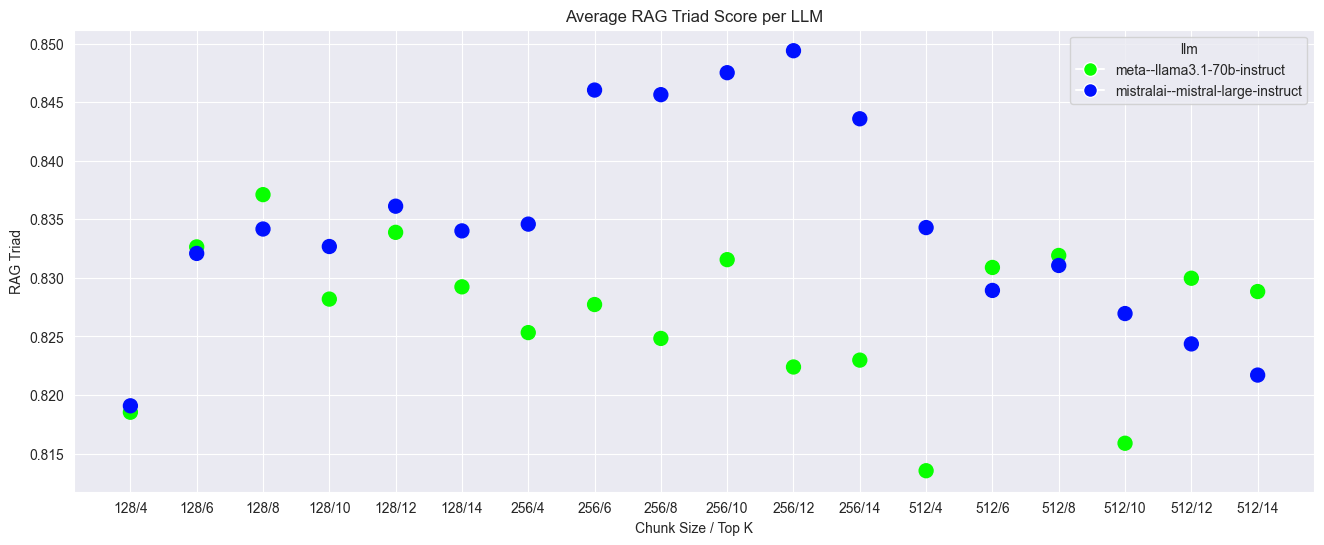

                                 llm  mean_rag_triad
1  mistralai--mistral-large-instruct        0.834572
0        meta--llama3.1-70b-instruct        0.826972


In [2]:
data_gen["rag_triad"] = (
    data_gen["mistralai--mistral-large-instruct_answer_relevance"] * 0.5
    + data_gen["meta--llama3.1-70b-instruct_groundedness"] * 0.25
    + data_gen["meta--llama3.1-70b-instruct_context_relevance_with_cot"] * 0.25
)
plot_metric(
    data_gen,
    "chunk_top_k",
    "rag_triad",
    "llm",
    "Chunk Size / Top K",
    "RAG Triad",
    "Average RAG Triad Score per LLM",
)

Answerable questions only

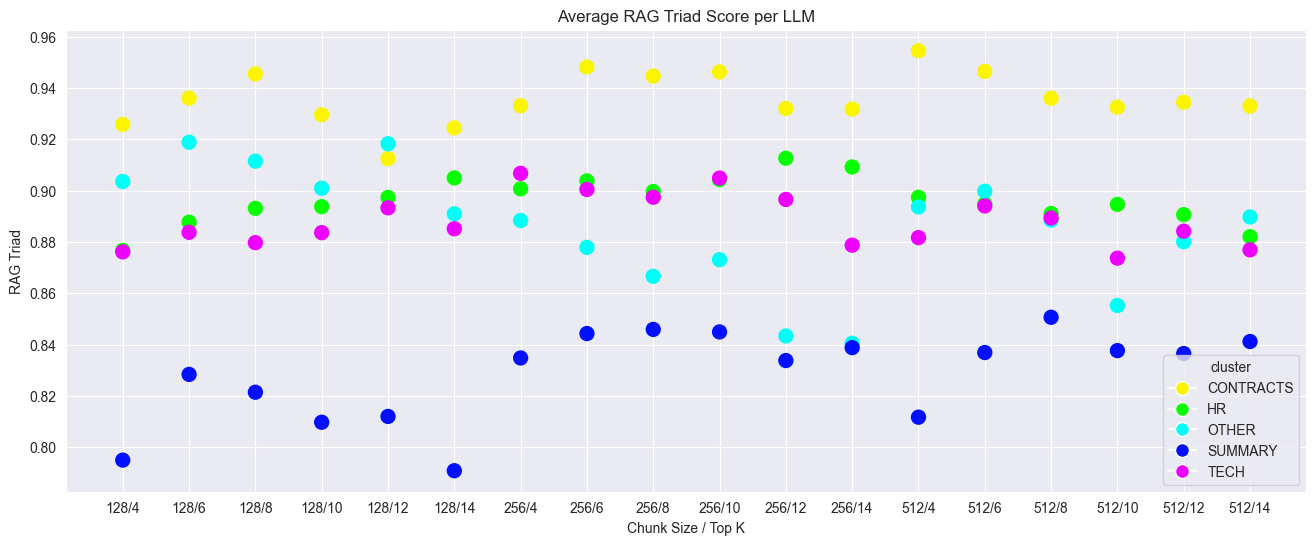

     cluster  mean_rag_triad
0  CONTRACTS        0.935889
1         HR        0.896343
4       TECH        0.888118
2      OTHER        0.885593
3    SUMMARY        0.828597


In [24]:
data_gen_f["rag_triad"] = (
    data_gen_f["mistralai--mistral-large-instruct_answer_relevance"] * 0.5
    + data_gen_f["meta--llama3.1-70b-instruct_groundedness"] * 0.25
    + data_gen_f["meta--llama3.1-70b-instruct_context_relevance_with_cot"] * 0.25
)
plot_metric(
    data_gen_f,
    "chunk_top_k",
    "rag_triad",
    "cluster",
    "Chunk Size / Top K",
    "RAG Triad",
    "Average RAG Triad Score per LLM",
)

## 2.4 Correlation Analysis
1. All Questions

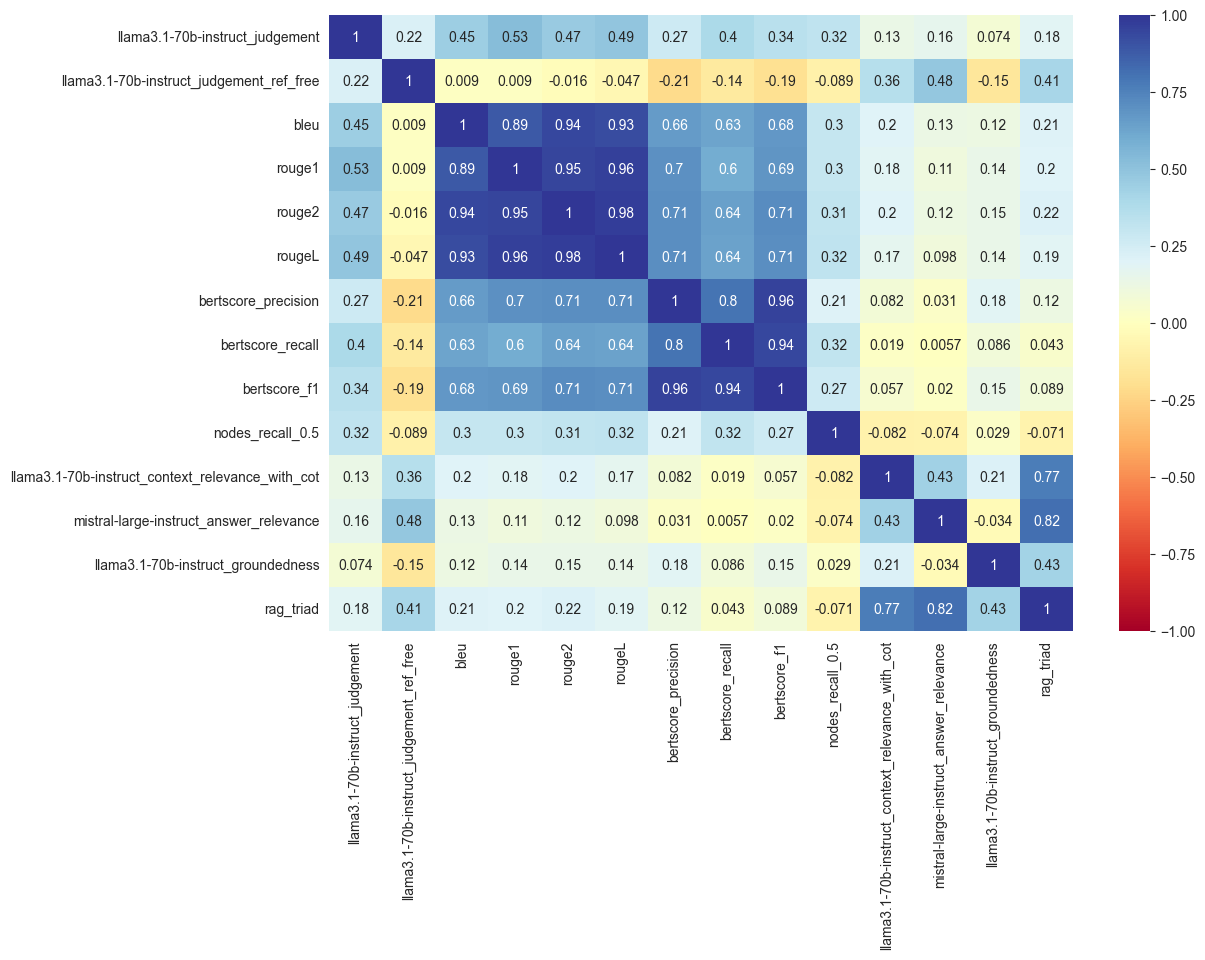

In [8]:
### 2.4 Correlation Analysis

plt.figure(figsize=(12, 8))
ax1 = plt.gca()
cols = [
    "meta--llama3.1-70b-instruct_judgement",
    "meta--llama3.1-70b-instruct_judgement_ref_free",
    "bleu",
    "rouge1",
    "rouge2",
    "rougeL",
    "bertscore_precision",
    "bertscore_recall",
    "bertscore_f1",
    "nodes_recall_0.5",
    "meta--llama3.1-70b-instruct_context_relevance_with_cot",
    "mistralai--mistral-large-instruct_answer_relevance",
    "meta--llama3.1-70b-instruct_groundedness",
    "rag_triad",
]
corr = data_gen[cols].corr()
labels = [j.split("--")[-1] for j in cols]
sns.heatmap(
    corr,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax1,
)
plt.show()

2. Answerable Questions only

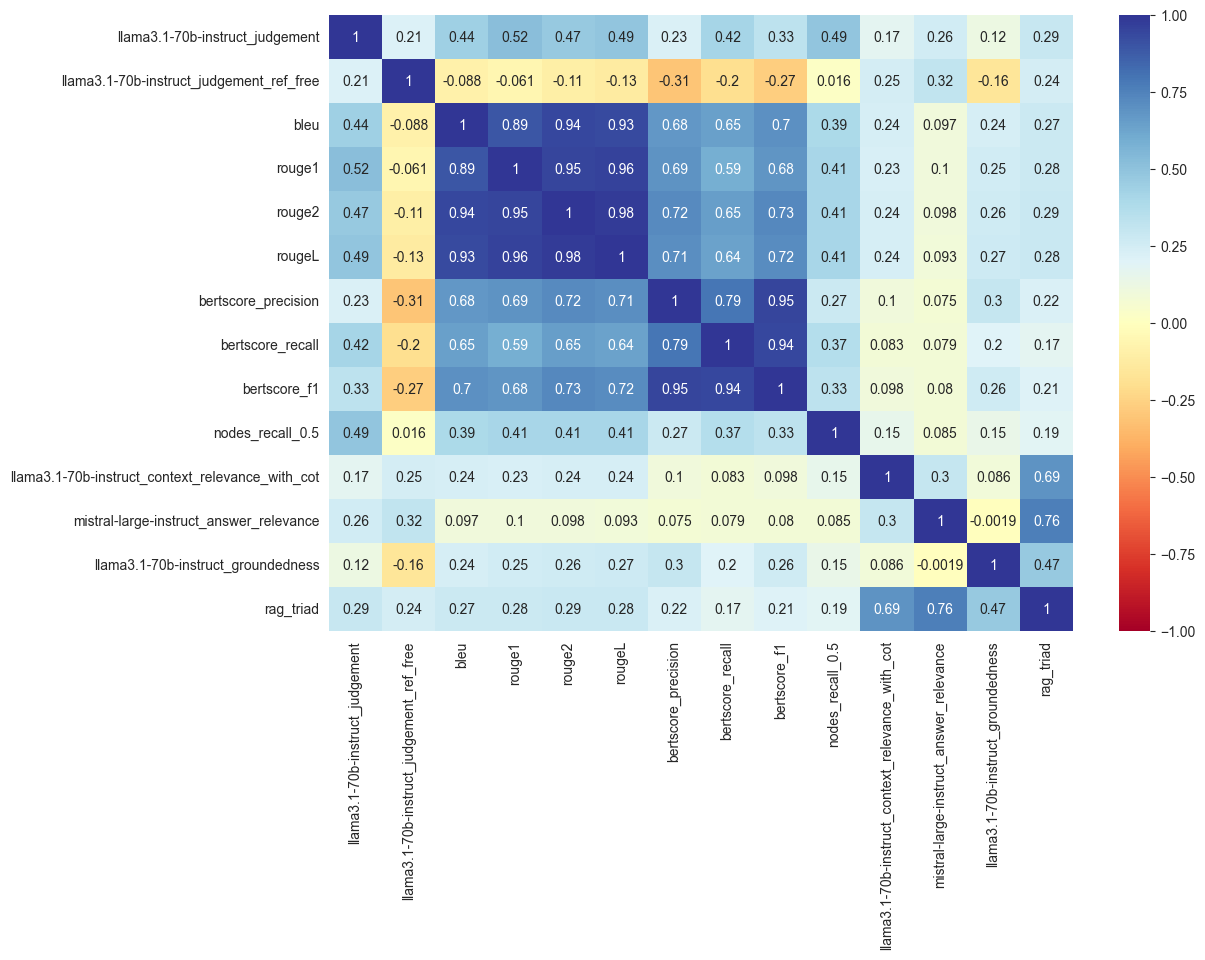

In [7]:
### 2.4 Correlation Analysis
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
cols = [
    "meta--llama3.1-70b-instruct_judgement",
    "meta--llama3.1-70b-instruct_judgement_ref_free",
    "bleu",
    "rouge1",
    "rouge2",
    "rougeL",
    "bertscore_precision",
    "bertscore_recall",
    "bertscore_f1",
    "nodes_recall_0.5",
    "meta--llama3.1-70b-instruct_context_relevance_with_cot",
    "mistralai--mistral-large-instruct_answer_relevance",
    "meta--llama3.1-70b-instruct_groundedness",
    "rag_triad",
]
corr = data_gen_f[cols].corr()
labels = [j.split("--")[-1] for j in cols]
sns.heatmap(
    corr,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax1,
)
plt.show()

# 3. Conclusions
Retrieval
- BGE-M3 significantly outperforms E5-Large
- BGE-Reranker performs the best, the other rerankers are worse than no rerank
- even at high context sizes, increasing it leads to significantly better results (in contrast to wikieval) -> more complex dataset and way more data
- summaries benefit the most from higher context sizes and have the lowest average recall

Generation
- LLM Judgement shows that Mistral is better than Llama and that the Reranker performs better than not using one
- it also shows that an increasing context size leads to better answers (up to 512/14)
- according to BLEU and ROUGE, Mistral is also better than Llama, although BERt-Score says the opposite
- ROUGE has the highest correlation with Judgement at 0.52 and BERT-Score the lowest at 0.34
- all metrics have a correlation with retrieval recall of around 0.3